In [1]:
import os
import sys
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle
from tensorflow import keras 
warnings.filterwarnings("ignore")
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

In [2]:
sys.path.append(os.path.join(os.path.dirname(os.path.dirname(os.getcwd())),'python-packages/'))
from deep_hashing_models import *
from similarities import *
from lsh_search import *

# 1. Data Preparation

In [3]:
data_repo = os.path.join(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))),'data/')

In [4]:
df_distinct_stacks = pd.read_csv(data_repo + 'frequent_stack_traces.csv', index_col = [0])
df_measures = pd.read_csv(data_repo + 'similarity-measures-pairs.csv', index_col = [0])

In [5]:
n_stacks = df_distinct_stacks.shape[0]
n_stacks

1000

In [6]:
vectorizer_bigram = CountVectorizer(token_pattern = r"(?u)\b[a-zA-Z0-9_.]{2,}\b", ngram_range=(2, 2))
s = df_distinct_stacks['stackTraceCusto'].apply(lambda x : x.replace('\n',' '))
s = s.apply(lambda x : x.replace('$',''))
s = s.apply(lambda x : x.replace('/',''))
s = s.apply(lambda x : x.replace('<',''))
s = s.apply(lambda x : x.replace('>',''))
X_bigram = vectorizer_bigram.fit_transform(list(s)).toarray()
df_bigram = pd.DataFrame(data = X_bigram, columns = vectorizer_bigram.get_feature_names())

In [7]:
X_train, X_validation, Y_train, Y_validation = train_test_split(df_measures.index, df_measures['Cosine-bigram'], test_size = 0.2) 

In [8]:
indexes_train_1 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_train_2 = X_train.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()
indexes_validation_1 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[0]).to_list()
indexes_validation_2 = X_validation.to_series().apply(lambda x : get_two_indexes(x, df_distinct_stacks.shape[0])[1]).to_list()

In [9]:
X_train = dict()
X_train['stack_1'] = df_bigram.loc[indexes_train_1].values
X_train['stack_2'] = df_bigram.loc[indexes_train_2].values

X_validation = dict()
X_validation['stack_1'] = df_bigram.loc[indexes_validation_1].values
X_validation['stack_2'] = df_bigram.loc[indexes_validation_2].values

In [10]:
Y_train = Y_train.values
Y_validation = Y_validation.values

In [11]:
assert X_train['stack_1'].shape == X_train['stack_2'].shape
assert len(X_train['stack_1']) == len(Y_train)

### Distribution of training data

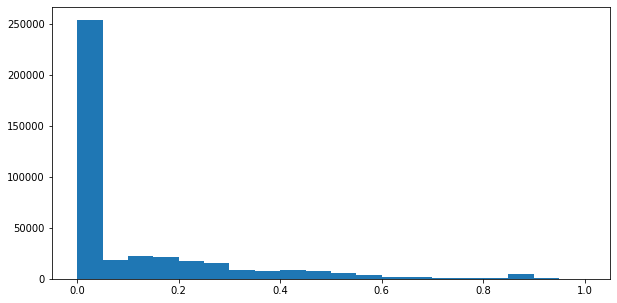

In [12]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_train, 20, alpha = 1, density = False)
plt.show()

### Distribution of test data

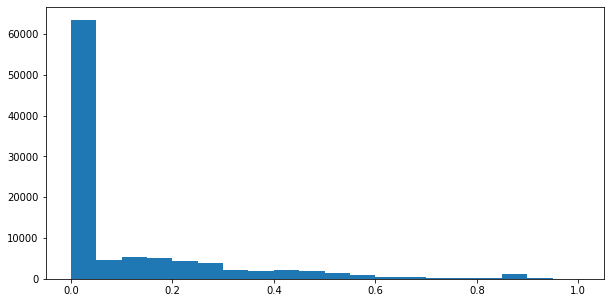

In [13]:
plt.rcParams["figure.figsize"] = [10, 5]
plt.hist(Y_validation, 20, alpha = 1, density = False)
plt.show()

# 2. Model Design

In [14]:
'Number of hash tables functions' 
m = 64

In [15]:
'Number of bits per hash function' 
b = 16

In [16]:
'Size hash vector'
size_hash_vector = m * b
size_hash_vector

1024

## 2.1. Feature learning phase

In [17]:
x = Sequential()
x.add(Dense(2048, input_dim = X_train['stack_1'].shape[1], activation = 'tanh'))
x.add(Dense(1024, activation = 'tanh'))
x.add(Dense(size_hash_vector, activation = 'tanh'))
shared_model = x

## 2.2. Siamese Model 

In [18]:
input_shape = (X_train['stack_1'].shape[1],)
model = siamese_model(shared_model, input_shape, b, m, is_sparse = True, print_summary = True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 3027)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 3027)]       0                                            
__________________________________________________________________________________________________
sequential (Sequential)         (None, 1024)         9349120     input_1[0][0]                    
                                                                 input_2[0][0]                    
                                                                 input_1[0][0]                    
                                                                 input_2[0][0]                

## 2.3. Model training 

In [19]:
siamese_model = train_siamese_model(model, X_train, X_validation, Y_train, Y_validation, batch_size = 512, epochs = 20)

Epoch 1/20
781/781 [==============================] - 36s 38ms/step - loss: 0.0043 - ham_dist_loss: 0.0042 - prod_vec_loss: 0.0122 - prod_vec_1_loss: 0.0123 - sum_vec_loss: 8.4893e-05 - sum_vec_1_loss: 8.1239e-05 - ham_dist_rmse: 0.0646 - ham_dist_mae: 0.0226 - val_loss: 8.6188e-04 - val_ham_dist_loss: 8.4145e-04 - val_prod_vec_loss: 0.0022 - val_prod_vec_1_loss: 0.0023 - val_sum_vec_loss: 6.4064e-05 - val_sum_vec_1_loss: 5.8834e-05 - val_ham_dist_rmse: 0.0290 - val_ham_dist_mae: 0.0127
Epoch 2/20
781/781 [==============================] - 28s 35ms/step - loss: 6.7308e-04 - ham_dist_loss: 6.6353e-04 - prod_vec_loss: 0.0015 - prod_vec_1_loss: 0.0016 - sum_vec_loss: 6.3595e-05 - sum_vec_1_loss: 6.1187e-05 - ham_dist_rmse: 0.0258 - ham_dist_mae: 0.0113 - val_loss: 6.0286e-04 - val_ham_dist_loss: 6.0326e-04 - val_prod_vec_loss: 0.0011 - val_prod_vec_1_loss: 0.0012 - val_sum_vec_loss: 5.9021e-05 - val_sum_vec_1_loss: 5.9498e-05 - val_ham_dist_rmse: 0.0246 - val_ham_dist_mae: 0.0106
Epoch 3/

# 3. Model Evaluation

In [20]:
model.layers

## 3.1. Loss functions

#### 3.1.1. MSE of $\mathcal{L}_{DeepLSH}$

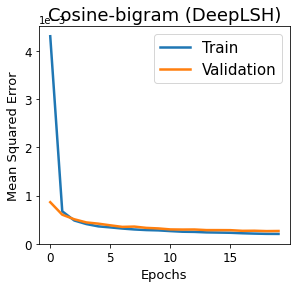

In [21]:
plt.rcParams["figure.figsize"] = (4.5,4)
plt.plot(siamese_model.history['loss'], linewidth = 2.5)
plt.plot(siamese_model.history['val_loss'], linewidth = 2.5)
plt.title('Cosine-bigram (DeepLSH)', fontsize = 18)
plt.ylabel('Mean Squared Error', fontsize = 13)
plt.xlabel('Epochs', fontsize = 13)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 12)
plt.ticklabel_format(axis = 'y', style='', scilimits=(0,0))
plt.savefig('Results/DeepLSH/loss-MSE.png', bbox_inches='tight')
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.2. RMSE of LSH preserving loss

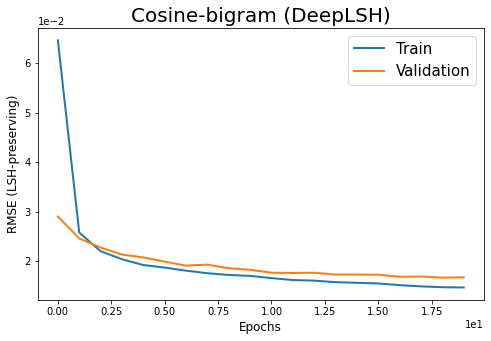

In [22]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_rmse'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_rmse'], linewidth = 2)
plt.title('Cosine-bigram (DeepLSH)', fontsize = 20)
plt.ylabel('RMSE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

#### 3.1.3. MAE of LSH preserving loss

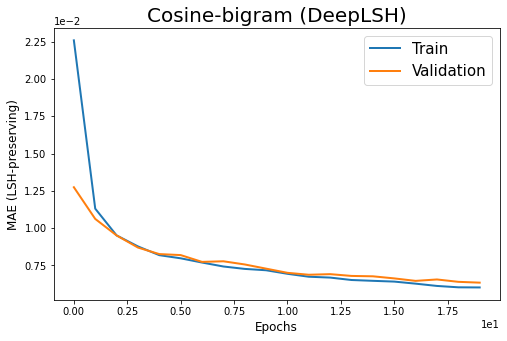

In [23]:
plt.rcParams["figure.figsize"] = (8,5)
plt.plot(siamese_model.history[model.layers[3].name + '_mae'], linewidth = 2)
plt.plot(siamese_model.history['val_' + model.layers[3].name + '_mae'], linewidth = 2)
plt.title('Cosine-bigram (DeepLSH)', fontsize = 20)
plt.ylabel('MAE (LSH-preserving)', fontsize = 12)
plt.xlabel('Epochs', fontsize = 12)
plt.ticklabel_format(style='', scilimits=(0,0))
plt.legend(['Train', 'Validation'], loc='upper right', fontsize=15)

## 3.2. Model Predictions

In [24]:
predictions = predict(model, X_validation)

### 3.2.1. Examples

In [25]:
np.around(predictions[0][:50],3) 

array([0.047, 0.438, 0.   , 0.   , 0.341, 0.062, 0.   , 0.   , 0.   ,
       0.203, 0.   , 0.   , 0.   , 0.   , 0.266, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.113, 0.   , 0.   , 0.   , 0.17 , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.109, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.86 , 0.094, 0.511, 0.   , 0.   , 0.125, 0.   , 0.   , 0.173,
       0.   , 0.   , 0.   , 0.   , 0.   ], dtype=float32)

In [26]:
np.around(Y_validation[:50],3) 

array([0.06 , 0.438, 0.   , 0.   , 0.336, 0.052, 0.   , 0.   , 0.   ,
       0.188, 0.   , 0.   , 0.   , 0.   , 0.269, 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.126, 0.   , 0.   , 0.   , 0.165, 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.135, 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.867, 0.098, 0.54 , 0.   , 0.   , 0.148, 0.   , 0.   , 0.178,
       0.   , 0.   , 0.   , 0.   , 0.   ])

### 3.2.2. Spearman $\rho$ and Kendall $\tau$ correlation

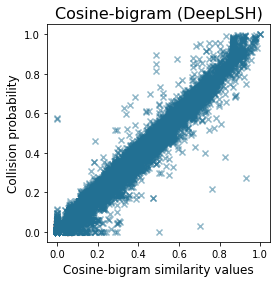

In [27]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(Y_validation, predictions[0], alpha = 0.5, marker = 'x', c = '#227093')
plt.title('Cosine-bigram (DeepLSH)', fontsize = 16)
plt.xlabel("Cosine-bigram similarity values", fontsize = 12)
plt.ylabel("Collision probability", fontsize = 12)
plt.savefig('Results/DeepLSH/Cosine-bigram-correlation', bbox_inches='tight')
plt.show()

In [28]:
rho, p_value = spearman_rho(predictions, Y_validation)
rho

0.899401445751352

In [29]:
tau, p_value = kendall_tau(predictions, Y_validation)
tau

0.8408598805488428

## 3.3. Approximate Hamming Evaluation

In [30]:
output_layer = 2
model.layers[output_layer]

In [31]:
intermediate_model = intermediate_model_trained(shared_model, output_layer)

In [32]:
intermediate_model.save('Models/model-deep-lsh.model')

INFO:tensorflow:Assets written to: Models/model-deep-lsh.model/assets


In [33]:
#intermediate_model = keras.models.load_model('Models/model-deep-lsh.model')

### 3.3.1. Example of a hash vector provided by the model (in the last epoch)

In [34]:
intermediate_model.predict(df_bigram.iloc[[10]])[0][:32]

array([ 1.,  1., -1., -1.,  1.,  1.,  1., -1., -1.,  1., -1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1., -1., -1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.], dtype=float32)

### 3.3.2. Average value of the absolute hash values

In [35]:
hash_vectors = intermediate_model.predict(df_bigram)

In [36]:
np.mean(np.abs(hash_vectors))

0.994978

### 3.3.3. Ratio of binary values from hash vectors provided by the model

In [37]:
hash_vectors[(hash_vectors == 1) | (hash_vectors == -1)].size / hash_vectors.size

0.864416015625

### 3.3.4. Comparison between approximate hamming and real hamming

In [38]:
df_hamming = compare_hamming(X_validation, intermediate_model, b, size_hash_vector)

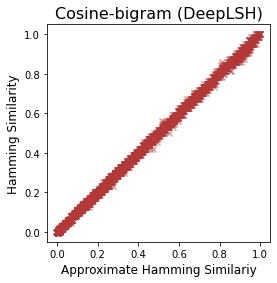

In [39]:
plt.rcParams["figure.figsize"] = (4,4)
plt.scatter(predictions[0], df_hamming['hamming'], alpha = 0.5, marker = 'x', c = '#b33939')
plt.xlabel("Approximate Hamming Similariy", fontsize = 12)
plt.ylabel("Hamming Similarity", fontsize = 12)
plt.title('Cosine-bigram (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Cosine-bigram-hamming-comparison', bbox_inches='tight')
plt.show()

# 4. Locality Sensitive Hashing

In [40]:
hash_vectors_hamming = convert_to_hamming(hash_vectors)

In [41]:
params = lsh_hyperparams(m)
'(K,L)'
params 

[(1, 64), (2, 32), (4, 16), (8, 8), (16, 4), (32, 2), (64, 1)]

## 4.1. Choose the best combination (L, K)


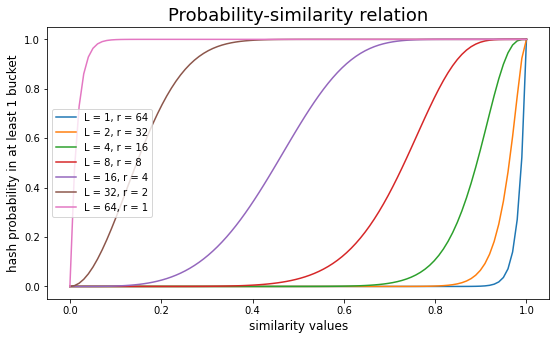

In [42]:
plt.rcParams["figure.figsize"] = [9, 5]
x = np.linspace(0, 1, 100)
for param in params:
    y = 1 - (1 - (x)**param[1])**param[0]
    plt.plot(x, y, label = 'L = %d, r = %d' %param)
plt.xlabel("similarity values", fontsize = 12)
plt.ylabel("hash probability in at least 1 bucket", fontsize = 12)
plt.title('Probability-similarity relation', fontsize = 18)
plt.legend()

In [43]:
df_probLSH = mean_prob_hashing_smallest_elt(n_stacks, params, hash_vectors_hamming, b, df_measures, 'Cosine-bigram', trace = False)

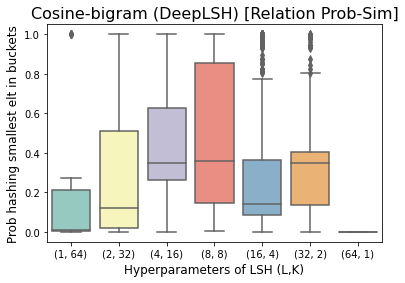

In [44]:
f, ax = plt.subplots(figsize=(6, 4))
ax = sns.boxplot(data = df_probLSH, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 12)
plt.ylabel("Prob hashing smallest elt in buckets", fontsize = 12)
plt.title('Cosine-bigram (DeepLSH) [Relation Prob-Sim]', fontsize = 16)
plt.savefig('Results/DeepLSH/Cosine-bigram-Relation-Prob-Sim', bbox_inches='tight')
plt.show()

In [45]:
'Exemple, L = K = 8'
L, K = params[3]
L, K

(8, 8)

In [46]:
df_probLSH.mean()['(4, 16)']

0.4433336820090139

In [47]:
df_probLSH.median()['(4, 16)']

0.347698879666668

## 4.2. Build hash tables with binary hash vectors w.r.t $K$ and $L$

In [48]:
hash_tables = create_hash_tables(L, K, b, hash_vectors_hamming)

In [49]:
with open('Hash-Tables/hash_tables_deeplsh.pkl', 'wb') as f:
    pickle.dump(hash_tables, f)

## 4.3. Search for approximate nearest neighbors (this procedure need to be explained in the paper) 

In [50]:
'pointer to the stack trace'
index = random.randint(0,n_stacks)
index

592

In [51]:
set_near_duplicates = near_duplicates(L, K, b, index, hash_vectors_hamming, hash_tables)
set_near_duplicates

{312,
 341,
 344,
 353,
 355,
 356,
 361,
 376,
 380,
 402,
 425,
 460,
 467,
 471,
 491,
 493,
 502,
 526,
 532,
 544,
 552,
 562,
 566,
 579,
 580,
 581,
 582,
 585,
 592,
 594,
 599,
 601,
 602,
 604,
 611,
 614,
 630,
 633,
 636,
 658,
 666,
 668,
 669,
 670,
 673,
 698,
 701,
 704,
 707,
 709,
 710,
 712,
 722,
 735,
 737,
 739,
 740,
 746,
 752,
 754,
 774,
 783,
 785,
 795,
 796,
 799,
 800,
 801,
 807,
 815,
 818,
 824,
 826,
 828,
 834,
 835,
 840,
 843,
 847,
 849,
 851,
 855,
 861,
 867,
 869,
 875,
 876,
 882,
 899,
 900,
 903,
 904,
 905,
 910,
 923,
 925,
 932,
 935,
 949,
 954,
 958,
 964,
 966,
 982,
 992}

In [52]:
list_near_duplicate_pairs = near_duplicate_pairs(index, set_near_duplicates, n_stacks)
n_duplicate_pairs = len(list_near_duplicate_pairs)

In [53]:
near_duplicates_sim = df_measures['Cosine-bigram'][list_near_duplicate_pairs].sort_values(ascending = False)
near_duplicates_sim

387464    0.866667
390281    0.866667
416761    0.866667
416755    0.866667
416754    0.866667
            ...   
416588    0.866667
416586    0.866667
416583    0.866667
416580    0.866667
375836    0.866667
Name: Cosine-bigram, Length: 104, dtype: float64

In [54]:
set_real_nns, real_nns_sim = real_nns(index, df_measures, 'Cosine-bigram', n_stacks, n_duplicate_pairs)
set_real_nns

{312,
 341,
 344,
 353,
 355,
 356,
 361,
 376,
 380,
 402,
 425,
 460,
 467,
 471,
 491,
 493,
 502,
 526,
 532,
 544,
 552,
 562,
 566,
 579,
 580,
 581,
 582,
 585,
 594,
 599,
 601,
 602,
 604,
 611,
 614,
 630,
 633,
 636,
 658,
 666,
 668,
 669,
 670,
 673,
 698,
 701,
 704,
 707,
 709,
 710,
 712,
 722,
 735,
 737,
 739,
 740,
 746,
 752,
 754,
 774,
 783,
 785,
 795,
 796,
 799,
 800,
 801,
 807,
 815,
 818,
 824,
 826,
 828,
 834,
 835,
 840,
 843,
 847,
 849,
 851,
 855,
 861,
 867,
 869,
 875,
 876,
 882,
 899,
 900,
 903,
 904,
 905,
 910,
 923,
 925,
 932,
 935,
 949,
 954,
 958,
 964,
 966,
 982,
 992}

In [55]:
real_nns_sim[:n_duplicate_pairs]

416552    0.866667
416589    0.866667
416547    0.866667
416548    0.866667
416549    0.866667
            ...   
416714    0.866667
416719    0.866667
416726    0.866667
416722    0.866667
282939    0.866667
Length: 104, dtype: float64

## 4.4. Metrics (DeepLSH for Cosine-bigram)

### 4.4.1. Ratio of finding the $k$ real nearest neighbor with the Least $L$ (Recal rate at $k$ first positions)

In [56]:
'All params'
k_first_positions = 1
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine-bigram')

0.836

In [57]:
'Best param'
k_first_positions = 1
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine-bigram')

0.9282051282051282

-----------------------------------------------------------------

In [58]:
'All params'
k_first_positions = 3
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine-bigram')

0.9099999999999996

In [59]:
'Best param'
k_first_positions = 3
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine-bigram')

0.9324473975636766

-----------------------------------------------------------------

In [60]:
'All params'
k_first_positions = 5
recal_rate(n_stacks, params, hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine-bigram')

0.9147999999999992

In [61]:
'Best param'
k_first_positions = 5
recal_rate_one_param(n_stacks, params[2], hash_vectors_hamming, b, df_measures, k_first_positions, 'Cosine-bigram')

0.953072625698324

### 4.4.2. Accuracy of finding the real nearest neighbors (Generalized MRR)

$ \frac{1}{|\mathcal{R}_i|} \sum_{s' \in \mathcal{R}_i} \frac{\text{rank}(s',\mathcal{R}_i)}{\text{rank}(s',NNs(s_i))} $

In [62]:
generalized_mrr(near_duplicates_sim, real_nns_sim)

1.0

In [63]:
df_knns = mean_generalized_mrr(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Cosine-bigram', trace = False)
df_knns.mean(skipna = True, axis = 0)

(1, 64)    0.941860
(2, 32)    0.957000
(4, 16)    0.941784
(8, 8)     0.902954
(16, 4)    0.912103
(32, 2)    0.958269
(64, 1)    0.994301
dtype: float64

In [64]:
df_knns.mean(skipna = True, axis = 0)['(4, 16)']

0.941784406482164

### 4.4.3. Recall w.r.t. LSH

In [65]:
df_recall = recall_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Cosine-bigram', trace = False)
df_recall.mean(skipna = True)

(1, 64)    1.000000
(2, 32)    0.507207
(4, 16)    0.681736
(8, 8)     0.788226
(16, 4)    0.820810
(32, 2)    0.822033
(64, 1)    0.977464
dtype: float64

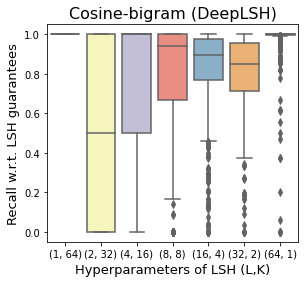

In [66]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_recall, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Recall w.r.t. LSH guarantees", fontsize = 13)
plt.title('Cosine-bigram (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/Recall-LSH', bbox_inches='tight')
plt.show()

### 4.4.4. Precision w.r.t. LSH

In [67]:
df_precision = precision_all(n_stacks, params, hash_vectors_hamming, b, df_measures ,'Cosine-bigram', trace = False)
df_precision.mean(skipna = True, axis = 0)

(1, 64)    0.116279
(2, 32)    0.304735
(4, 16)    0.457938
(8, 8)     0.720823
(16, 4)    0.744337
(32, 2)    0.898931
(64, 1)    0.879224
dtype: float64

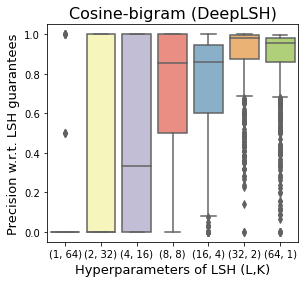

In [68]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_precision, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("Precision w.r.t. LSH guarantees", fontsize = 13)
plt.title('Cosine-bigram (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/precision-LSH', bbox_inches='tight')
plt.show()

### 4.4.5. Fscore w.r.t. LSH

In [69]:
df_score_all = fscore_all(df_precision, df_recall)
df_score_all.mean(skipna = True)

(1, 64)    0.124031
(2, 32)    0.245526
(4, 16)    0.403259
(8, 8)     0.682347
(16, 4)    0.730781
(32, 2)    0.836253
(64, 1)    0.916359
dtype: float64

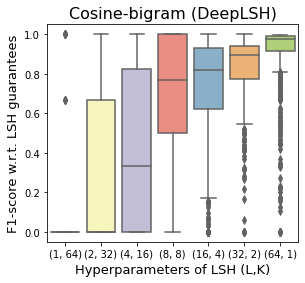

In [70]:
f, ax = plt.subplots(figsize=(4.5, 4))
ax = sns.boxplot(data = df_score_all, palette="Set3")
plt.xlabel("Hyperparameters of LSH (L,K)", fontsize = 13)
plt.ylabel("F1-score w.r.t. LSH guarantees", fontsize = 13)
plt.title('Cosine-bigram (DeepLSH)', fontsize = 16)
plt.savefig('Results/DeepLSH/fscore-LSH', bbox_inches='tight')
plt.show()